## 1. Carregamento do Dataset via Kaggle API

Nesta célula, iniciamos o projeto importando o `kagglehub`, a biblioteca oficial do Kaggle para interagir com datasets.

Utilizamos a função `kagglehub.dataset_download` para baixar programaticamente o conjunto de dados "Heart Disease UCI" (identificado como `johnsmith88/heart-disease-dataset`). Este método é preferível ao upload manual de arquivos (como `heart.csv`), pois:

1.  **Reprodutibilidade:** Garante que qualquer pessoa executando este notebook utilize exatamente a mesma fonte de dados original.
2.  **Eficiência:** O Colab pode utilizar o cache para acelerar o acesso ao dataset em sessões futuras.

A variável `path` armazena o caminho local onde os dados foram baixados, que será usada na etapa de leitura do CSV.

In [316]:
# Download do dataset diretamente do Kaggle
import kagglehub

# Download da versão mais recente do dataset
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")

print("/content/heart.xls", path)

Using Colab cache for faster access to the 'heart-disease-dataset' dataset.
/content/heart.xls /kaggle/input/heart-disease-dataset


## 2. Importação das Bibliotecas Fundamentais e Verificação de Versões

Esta célula carrega as bibliotecas essenciais para o fluxo de trabalho de *Machine Learning* e *Deep Learning*.

* **`pandas`**: Utilizada para a leitura e manipulação de dados em formato de DataFrame. É a principal ferramenta para carregar o arquivo `.csv` e realizar a análise exploratória.
* **`numpy`**: Fornece a base para operações numéricas e matriciais de alta performance. O Keras, por baixo dos panos, depende do NumPy para processar os dados.
* **`sklearn` (Scikit-learn)**: A biblioteca padrão para *Machine Learning* em Python. Neste projeto, ela é fundamental para:
    * `train_test_split`: Dividir nossos dados em conjuntos de treino e teste.
    * `StandardScaler`: Realizar a normalização das *features*, um passo crítico para redes neurais, como destacado na descrição do trabalho.
* **`keras`**: A API de alto nível (agora parte do TensorFlow) que usaremos para construir, compilar e treinar nossa Rede Neural Artificial (ANN).
* **`sys`**: Usado aqui para imprimir a versão do Python.

A impressão das versões (`__version__`) é uma boa prática que assegura a **reprodutibilidade** do experimento, registrando o ambiente exato em que o código foi executado.

In [317]:
# Importação das bibliotecas principais
import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import keras

# Verificar versões instaladas
print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Keras: {}'.format(keras.__version__))

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
Sklearn: 1.6.1
Matplotlib: 3.10.0
Keras: 3.10.0


## 3. Configuração do Ambiente de Visualização

Importamos `matplotlib.pyplot` e `seaborn`, as duas principais bibliotecas de visualização em Python.

* **`matplotlib`**: A biblioteca base para a criação de gráficos estáticos.
* **`seaborn`**: Construída sobre o `matplotlib`, ela oferece uma interface de mais alto nível para gráficos estatísticos complexos, como a matriz de correlação (heatmap) e gráficos de distribuição.
* **`sns.set_style("whitegrid")`**: Define um estilo visual limpo e profissional (com fundo branco e grades) para todos os gráficos subsequentes.

In [318]:
# Importação de bibliotecas para visualização
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

# Configurar estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 4. Carregamento e Inspeção Inicial dos Dados

Utilizamos o `pandas.read_csv` para carregar o arquivo `heart.csv` (localizado pelo `path` definido na Célula 1) em um DataFrame chamado `cleveland`.

Imediatamente, inspecionamos os dados:
* **`.shape`**: Revela a dimensão do DataFrame.A saída inicial de `(1025, 14)` indica 1025 registros (pacientes) e 14 colunas (13 atributos clínicos + 1 variável-alvo).
* **`.head()`**: Mostra as primeiras 5 linhas, permitindo uma verificação visual dos atributos (como `age`, `sex`, `chol`) e da variável-alvo (`target`).

In [319]:
# Carregar o dataset
cleveland = pd.read_csv(f'{path}/heart.csv')

# Visualizar informações básicas
print('Shape do DataFrame: {}'.format(cleveland.shape))
print('\nPrimeiras linhas do dataset:')
print(cleveland.head())

Shape do DataFrame: (1025, 14)

Primeiras linhas do dataset:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


## 5. Análise Exploratória de Dados (EDA) - Tipos e Escalas

Continuamos a análise exploratória para entender a estrutura e a qualidade dos dados.

* **`.info()`**: Este comando é vital para verificar:
    * **Valores Nulos:** A saída "1025 non-null" para todas as colunas sugere que, nesta versão do dataset, não há dados ausentes (NaN).
    * **Tipos de Dados (Dtypes):** Todas as colunas são numéricas (`int64` ou `float64`), o que é ideal para alimentar uma rede neural. Nenhuma conversão de dados categóricos (como *one-hot encoding*) é necessária.

* **`.describe()`**: Esta é a análise mais importante desta etapa. Ela revela a estatística descritiva e **confirma a premissa central do projeto**:
    * As *features* possuem escalas vastamente diferentes (e.g., `age` [29-77] vs. `chol` vs. `oldpeak` [0-6.2]).
    * **Importância para a ANN:** Se alimentássemos esses dados brutos na rede, as *features* com maiores magnitudes (como `chol`) dominariam o processo de aprendizado e a otimização (gradiente descendente), impedindo o modelo de convergir eficientemente. Isso justifica a **necessidade obrigatória de normalização** (Padronização) que faremos mais adiante.

In [320]:
# Visualizar informações sobre as colunas
print('Informações do Dataset:')
print(cleveland.info())
print('\nEstatísticas Descritivas:')
print(cleveland.describe())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Estatísticas Descritivas:
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.43

## 6. Limpeza e Pré-processamento: Remoção de Duplicatas

Esta célula executa uma etapa de limpeza de dados fundamental.

1.  **`.copy()`**: Criamos uma cópia do DataFrame (`data`) para garantir que o DataFrame original (`cleveland`) permaneça intacto. Esta é uma prática recomendada para evitar avisos (`SettingWithCopyWarning`).
2.  **Verificação de Duplicatas**: `data.duplicated().sum()` identificou **723 linhas duplicadas**.
3.  **Remoção de Duplicatas**: `data.drop_duplicates()` é chamado para remover essas linhas.

**Análise:** O dataset original da UCI possui cerca de 303 pacientes. A versão carregada do Kaggle tinha 1025 linhas. Ao remover 723 duplicatas, nosso DataFrame é reduzido para `(302, 14)`, o que se alinha perfeitamente com a fonte original e garante que nosso modelo não seja treinado em dados redundantes (o que causaria *overfitting* e métricas infladas).

Também incluímos `data[~data.isin(['?'])]` e `data.dropna()` como medidas robustas para garantir a remoção de quaisquer marcadores de dados ausentes (`?` ou `NaN`) que possam ter restado.

In [321]:
# Verificar últimas linhas antes da limpeza
print('Últimas linhas ANTES da limpeza:')
print(cleveland.loc[280:])

# --- NOVO BLOCO PARA REMOVER DUPLICATAS ---

# Copiar os dados para uma nova variável 'data'
data = cleveland.copy()

# 1. Verificar quantas duplicatas existem
duplicatas = data.duplicated().sum()
print(f"Total de linhas duplicadas encontradas: {duplicatas}")

# 2. Remover as duplicatas (se existirem)
if duplicatas > 0:
    data = data.drop_duplicates()
    print(f"Duplicatas removidas. Novo shape do data: {data.shape}")
else:
    print("Nenhuma duplicata encontrada.")

# remove missing data (indicated with a "?")
data = data[~data.isin(['?'])]

# Remover linhas com valores NaN
data = data.dropna(axis=0)

print('\nÚltimas linhas DEPOIS da limpeza:')
print(data.loc[280:])

Últimas linhas ANTES da limpeza:
      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
280    45    0   1       130   234    0        0      175      0      0.6   
281    35    1   1       122   192    0        1      174      0      0.0   
282    41    0   1       130   204    0        0      172      0      1.4   
283    64    1   3       110   211    0        0      144      1      1.8   
284    58    1   2       132   224    0        0      173      0      3.2   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  thal  target  
280       

## 7. Confirmação Pós-Limpeza e Conversão Numérica

Após a remoção das duplicatas, verificamos novamente o `shape` (agora 302, 14) e os `dtypes`.

A linha `data = data.apply(pd.to_numeric)` é uma salvaguarda de robustez. Embora o `.info()` anterior não tenha mostrado colunas não numéricas, algumas versões deste dataset podem conter valores como '?' (que não seriam `NaN` e sim `object`). Esta função garante que todas as colunas sejam forçadas para um formato numérico.

In [322]:
# Verificar shape e tipos de dados após limpeza
print('Shape após limpeza:', data.shape)
print('\nTipos de dados:')
print(data.dtypes)

# Converter todos os dados para numérico
data = data.apply(pd.to_numeric)

print('\nTipos de dados após conversão:')
print(data.dtypes)

Shape após limpeza: (302, 14)

Tipos de dados:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Tipos de dados após conversão:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


## 8. Análise do Balanceamento de Classes

Após a limpeza, realizamos duas verificações finais:

1.  **`.describe()`**: Re-executamos a estatística descritiva nos 302 registros limpos. A análise se mantém: as escalas das *features* continuam amplamente diferentes, reforçando a necessidade da normalização.
2.  **`data['target'].value_counts()`**: Esta é uma verificação crítica para qualquer problema de classificação. Analisamos a distribuição da nossa variável-alvo:
    * **Classe 1 (Com Doença):** 164 amostras (54.3%)
    * **Classe 0 (Sem Doença):** 138 amostras (45.7%)

**Conclusão:** O dataset está **bem balanceado**. Não há um desequilíbrio de classe significativo (como 90%/10%). Isso é importante porque significa que a **Acurácia** será uma métrica de avaliação confiável para o nosso modelo, conforme solicitado na descrição do trabalho.

In [323]:
# Estatísticas descritivas detalhadas
print('Estatísticas Descritivas Completas:')
print(data.describe())

# Verificar distribuição da variável target
print('\n🎯 Distribuição da Variável Target:')
print(data['target'].value_counts())
print(f'\nPercentual com doença: {(data["target"].sum() / len(data)) * 100:.2f}%')

Estatísticas Descritivas Completas:
             age         sex          cp    trestbps        chol         fbs  \
count  302.00000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean    54.42053    0.682119    0.963576  131.602649  246.500000    0.149007   
std      9.04797    0.466426    1.032044   17.563394   51.753489    0.356686   
min     29.00000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.00000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.50000    1.000000    1.000000  130.000000  240.500000    0.000000   
75%     61.00000    1.000000    2.000000  140.000000  274.750000    0.000000   
max     77.00000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  302.000000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean     0.526490  149.569536    0.327815    1.043046    1.397351    0.718543   


## 9. Visualização da Distribuição das *Features*

Como etapa final da Análise Exploratória, plotamos histogramas para todas as 14 variáveis. Esta visualização nos ajuda a entender a distribuição de cada atributo:

* **Distribuições Gaussianas:** Variáveis como `age` (idade), `trestbps` (pressão arterial) e `chol` (colesterol) se aproximam de uma distribuição normal (gaussiana).
* **Distribuições Binárias/Categóricas:** Variáveis como `sex`, `fbs` (glicemia) e `target` (alvo) são claramente binárias. Outras, como `cp` (tipo de dor no peito) e `ca`, são categóricas.
* **Distribuições Enviesadas (Skewed):** A variável `oldpeak` é fortemente enviesada à direita.

Essa análise é relevante pois o `StandardScaler` (que usaremos a seguir) funciona melhor em dados com distribuição próxima da normal.

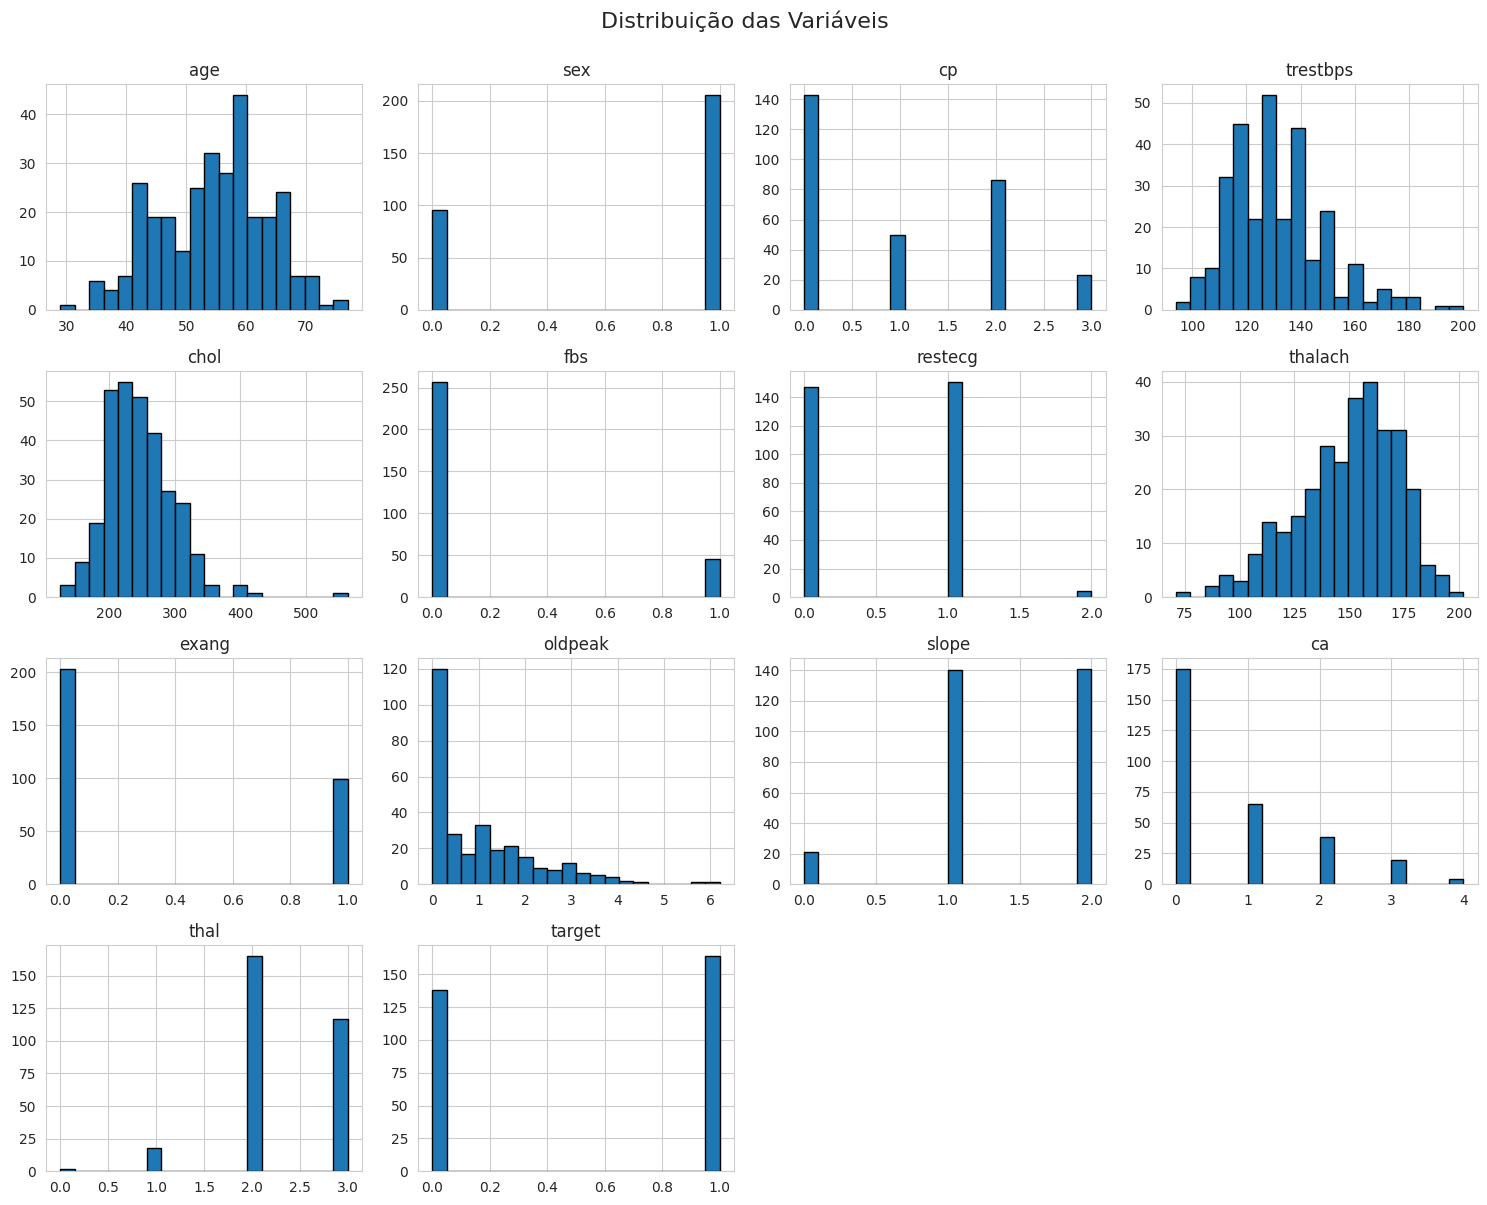

In [324]:
# Histogramas de todas as variáveis
data.hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle('Distribuição das Variáveis', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 10. Análise Visual: Frequência de Doença por Idade

Este gráfico de barras (`crosstab`) compara a frequência de pacientes com doença (1) e sem doença (0) distribuídos por idade.

**Análise:**
* Em idades mais jovens (aprox. < 50 anos), a frequência de pacientes "Sem Doença" (azul) é visivelmente maior.
* À medida que a idade avança (aprox. > 54 anos), a proporção se inverte, e a frequência de pacientes "Com Doença" (vermelho) torna-se dominante.
* Isso confirma visualmente que a **idade (`age`) é um forte preditor** para a doença cardíaca, justificando sua importância como *feature* no modelo.

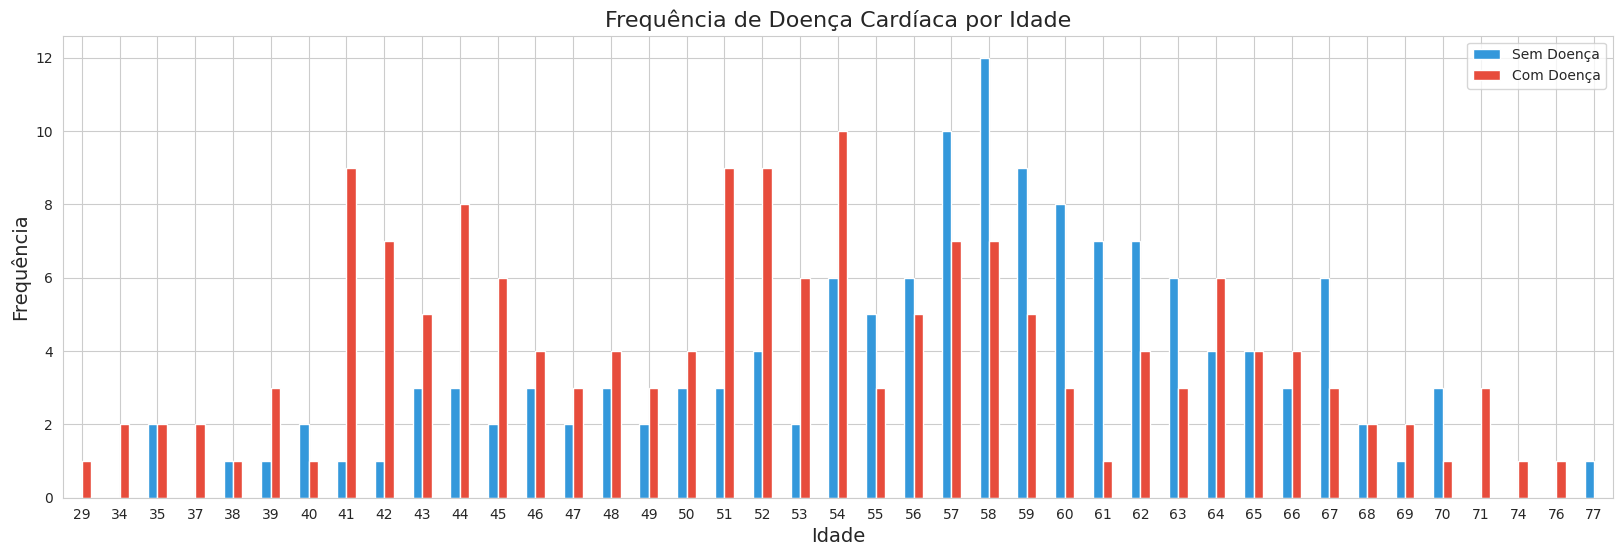

In [325]:
# Frequência de doenças cardíacas por idade
pd.crosstab(data.age, data.target).plot(kind="bar", figsize=(20, 6), color=['#3498db', '#e74c3c'])
plt.title('Frequência de Doença Cardíaca por Idade', fontsize=16)
plt.xlabel('Idade', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.legend(['Sem Doença', 'Com Doença'])
plt.xticks(rotation=0)
plt.show()

## 11. Análise Visual: Matriz de Correlação (Heatmap)

Esta matriz de correlação visualiza a relação linear entre todas as variáveis do dataset.

**Análise das Correlações com `target`:**
* **Correlação Positiva (tons de vermelho):** `cp` (tipo de dor no peito), `thalach` (freq. cardíaca máxima) e `slope` (inclinação do ST) têm as correlações positivas mais fortes com o `target`. Isso significa que, à medida que esses valores aumentam, a probabilidade de ter a doença também aumenta.
* **Correlação Negativa (tons de azul):** `exang` (angina induzida por exercício), `oldpeak`, `ca` (nº de vasos principais) e `thal` (talassemia) têm as correlações negativas mais fortes. À medida que esses valores aumentam, a probabilidade de ter a doença diminui.

Esta análise confirma que as *features* selecionadas têm, de fato, poder preditivo sobre a variável-alvo.

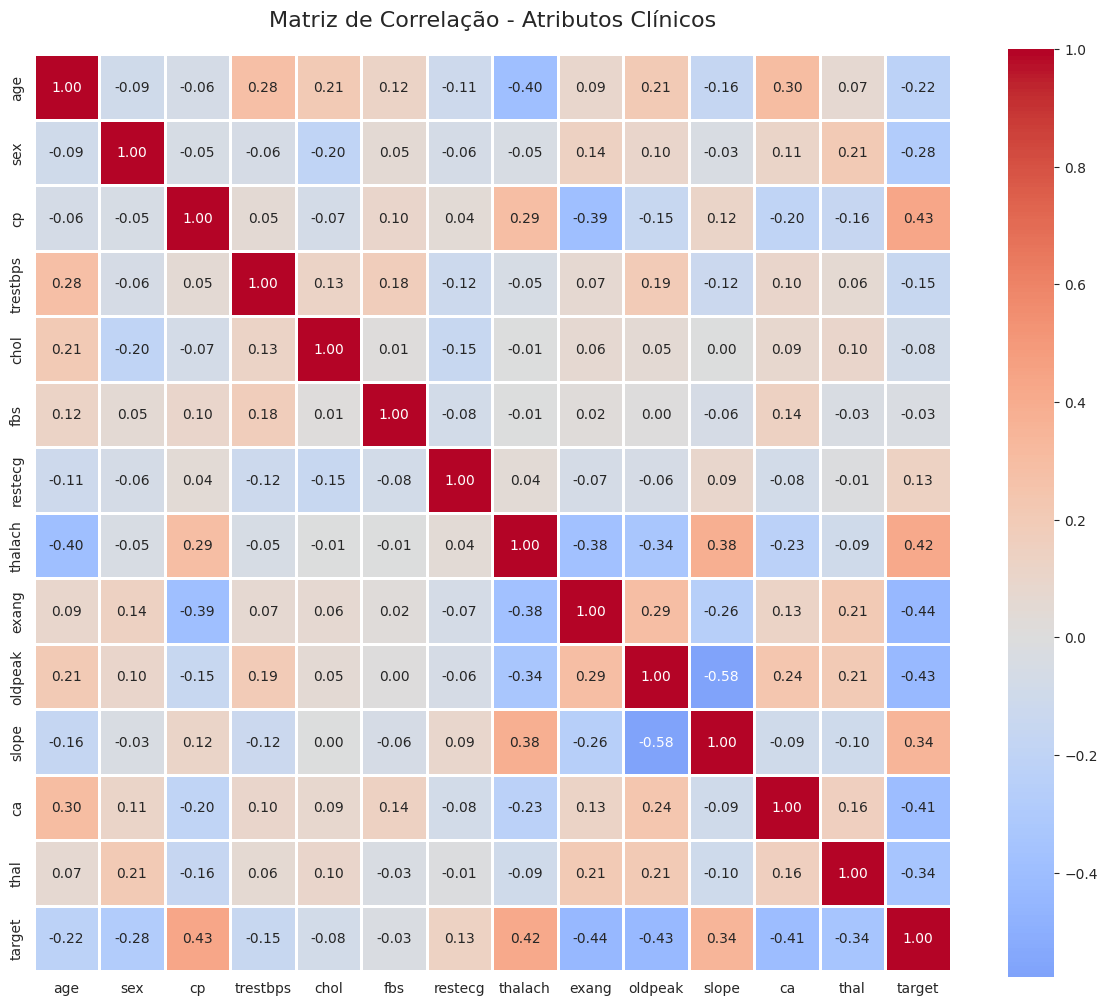

In [326]:
# Mapa de calor da correlação entre variáveis
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(),
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1)
plt.title('Matriz de Correlação - Atributos Clínicos', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

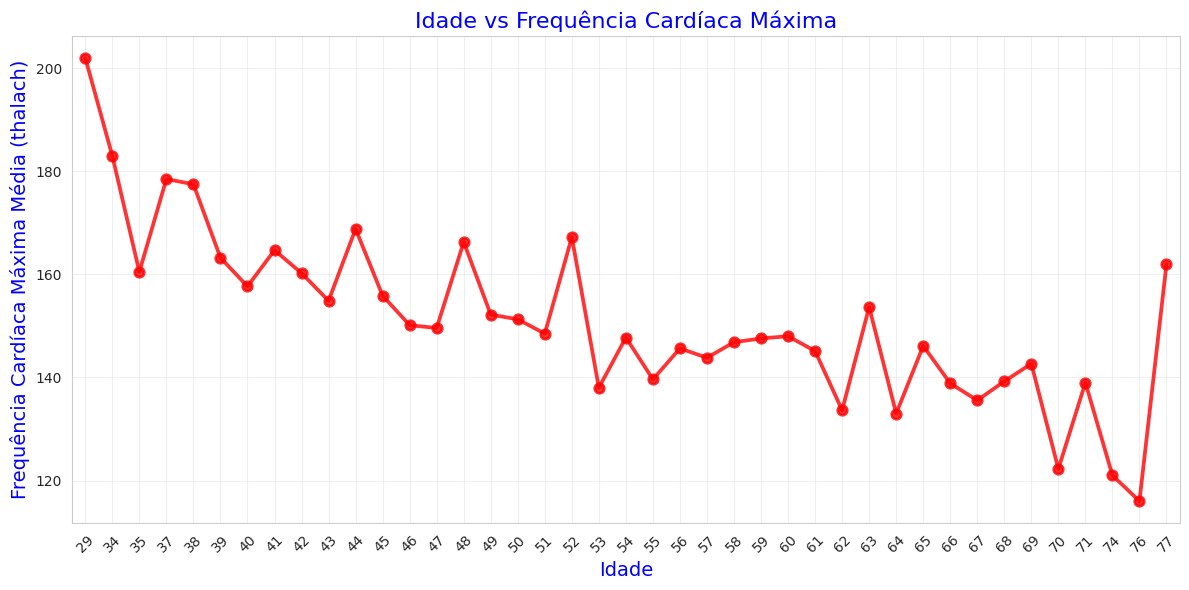

In [327]:
# Relação entre idade e frequência cardíaca máxima (thalach)
age_unique = sorted(data.age.unique())
age_thalach_values = data.groupby('age')['thalach'].count().values
mean_thalach = []

for i, age in enumerate(age_unique):
    mean_thalach.append(sum(data[data['age'] == age].thalach) / age_thalach_values[i])

plt.figure(figsize=(12, 6))
sns.pointplot(x=age_unique, y=mean_thalach, color='red', alpha=0.8)
plt.xlabel('Idade', fontsize=14, color='blue')
plt.xticks(rotation=45)
plt.ylabel('Frequência Cardíaca Máxima Média (thalach)', fontsize=14, color='blue')
plt.title('Idade vs Frequência Cardíaca Máxima', fontsize=16, color='blue')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Separação de *Features* (X) e Alvo (y)

Neste passo, dividimos nosso DataFrame limpo em duas matrizes NumPy, que é o formato esperado pelas bibliotecas `sklearn` e `keras`:

* **`X` (Features/Atributos):** Contém todas as 13 colunas de atributos clínicos (independentes), excluindo a coluna `target`.
* **`y` (Target/Alvo):** Contém apenas a variável-alvo (dependente), `target`, que nosso modelo tentará prever (0 ou 1).

O uso de `.values` converte os objetos `pandas` diretamente em `numpy.ndarray`.

In [328]:
# Separar features (X) e target (y)
X = data.drop(['target'], axis=1).values
y = data['target'].values

print('Shape de X (features):', X.shape)
print('Shape de y (target):', y.shape)
print('\nExemplo de features (primeira linha):')
print(X[0])

Shape de X (features): (302, 13)
Shape de y (target): (302,)

Exemplo de features (primeira linha):
[ 52.   1.   0. 125. 212.   0.   1. 168.   0.   1.   2.   2.   3.]


## 14. Divisão dos Dados em Conjuntos de Treino e Teste

Utilizamos a função `train_test_split` do `sklearn` para segmentar nossos dados. Esta é a etapa mais importante para uma avaliação honesta do modelo.

* **Dados de Treino (`X_train`, `y_train`):** 80% dos dados (241 amostras) que serão usados para *ensinar* a rede neural a reconhecer os padrões.
* **Dados de Teste (`X_test`, `y_test`):** 20% dos dados (61 amostras) que o modelo *nunca viu*. Usaremos este conjunto ao final para avaliar se o modelo consegue **generalizar** seu aprendizado para novos pacientes.

Parâmetros críticos utilizados:
* `test_size=0.2`: Define a proporção 80/20 para treino/teste.
* `random_state=42`: Garante a reprodutibilidade.
* `stratify=y`: Assegura que a proporção de classes (54.3% / 45.7%) seja mantida tanto no conjunto de treino quanto no de teste, evitando um viés na amostragem.

In [329]:
# Dividir em treino e teste antes de normalizar
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,      # Mantém a proporção de classes
    random_state=42, # Reprodutibilidade
    test_size=0.2    # 20% para teste
)

print('Dados divididos em treino e teste:')
print(f'   Treino: {X_train.shape[0]} amostras')
print(f'   Teste:  {X_test.shape[0]} amostras')
print(f'\nDistribuição das classes no treino: {np.bincount(y_train)}')
print(f' Distribuição das classes no teste:  {np.bincount(y_test)}')

Dados divididos em treino e teste:
   Treino: 241 amostras
   Teste:  61 amostras

Distribuição das classes no treino: [110 131]
 Distribuição das classes no teste:  [28 33]


## 15. Normalização de *Features* (StandardScaler)

Esta é a etapa de pré-processamento mais crucial para este projeto. Como vimos na EDA (Célula 5), as *features* têm escalas muito diferentes.

Usamos o `StandardScaler` do `sklearn`, que executa a **Padronização**: ele transforma cada *feature* para que ela tenha uma **média (μ) de 0** e um **desvio padrão (σ) de 1**. A fórmula aplicada é $z = (x - \mu) / \sigma$.

Isso é vital para Redes Neurais, pois garante que todas as *features* contribuam de forma equilibrada para o cálculo do gradiente, permitindo uma convergência muito mais rápida e estável.

**Fluxo de Aplicação Correto (Evitando *Data Leakage*):**
1.  **`scaler.fit_transform(X_train)`**: O scaler "aprende" (calcula μ e σ) **apenas** com os dados de treino e, em seguida, os transforma.
2.  **`scaler.transform(X_test)`**: O scaler aplica a **mesma** transformação (usando o μ e σ do treino) aos dados de teste.

Nunca se deve usar `fit` ou `fit_transform` nos dados de teste, pois isso contaminaria o processo de avaliação com informações que o modelo não deveria "conhecer" antecipadamente.

In [330]:
#  aplicar StandardScaler (DEPOIS da divisão)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform no treino (aprende média e desvio padrão)
X_train = scaler.fit_transform(X_train)

# transform no teste (aplica a mesma transformação)
X_test = scaler.transform(X_test)

print('Normalização concluída!')
print(f'\nMédia das features após normalização (treino): {X_train.mean(axis=0)}')
print(f'Desvio padrão das features após normalização (treino): {X_train.std(axis=0)}')
print(f'\nExemplo de dado normalizado:')
print(X_train[0])

Normalização concluída!

Média das features após normalização (treino): [-3.20628724e-16 -3.00359092e-16 -4.42246516e-17 -7.87290933e-16
  3.17864683e-17  2.90224276e-17 -2.46920971e-16  3.22316660e-16
 -2.57977134e-16 -1.26030180e-16  8.56852625e-17  8.06178545e-19
 -4.59752107e-16]
Desvio padrão das features após normalização (treino): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Exemplo de dado normalizado:
[ 1.42194408 -1.44559455  0.98649276 -0.97304069  5.88290757 -0.39831375
 -1.00805864  0.4082403  -0.65271395  0.52726339 -0.69712735 -0.72271635
  1.07583844]


## 16. Garantia de Classificação Binária

O objetivo do projeto é construir um **classificador binário** (0: Ausência, 1: Presença). O dataset original da UCI, em algumas versões, utiliza valores de 1 a 4 para indicar diferentes níveis de severidade da doença.

Esta célula atua como uma salvaguarda. Ela garante que qualquer valor na variável-alvo que seja maior que 0 (seja 1, 2, 3 ou 4) seja mapeado para **1**.

Isso consolida o problema como uma classificação binária estrita: "Sem Doença" (0) vs. "Qualquer Nível de Doença" (1).

In [331]:
# Garantir que os labels sejam binários (0 ou 1)
# Alguns datasets podem ter valores > 1 para diferentes graus de doença
y_train_binary = y_train.copy()
y_test_binary = y_test.copy()

y_train_binary[y_train_binary > 0] = 1
y_test_binary[y_test_binary > 0] = 1

print('Labels convertidos para binário:')
print(f'   Labels únicos no treino: {np.unique(y_train_binary)}')
print(f'   Labels únicos no teste:  {np.unique(y_test_binary)}')

Labels convertidos para binário:
   Labels únicos no treino: [0 1]
   Labels únicos no teste:  [0 1]


## 17. Construção da Arquitetura da Rede Neural (ANN)

Esta célula define a arquitetura da nossa Rede Neural Artificial (ANN) *Feedforward* usando a API `Sequential` do Keras, conforme os requisitos do trabalho.

1.  **`Input(shape=(13,))`**: Define a camada de entrada, que espera vetores com nossos 13 atributos clínicos.
2.  **1ª Camada Oculta (`Dense(16, ...)`):**
    * **`Dense(16)`**: Uma camada totalmente conectada com 16 neurônios.
    * **`activation='relu'`**: Utiliza a ativação **ReLU** (Unidade Linear Retificada).Esta é a ativação padrão para camadas ocultas, pois combate o problema do "desvanecimento do gradiente" (vanishing gradient) e é computacionalmente eficiente.
3.  **Regularização (L2 e Dropout):** Para prevenir o *overfitting* (quando o modelo decora os dados de treino em vez de aprender a generalizar):
    * **`kernel_regularizer=l2(0.001)`**: Aplica a regularização L2 (*Weight Decay*), que penaliza pesos muito grandes, mantendo o modelo mais simples.
    * **`Dropout(0.25)`**: Durante o treino, desativa aleatoriamente 25% dos neurônios da camada anterior em cada passo. Isso força a rede a aprender caminhos redundantes e a não depender de neurônios específicos, melhorando a generalização.
4.  **2ª Camada Oculta (`Dense(8, ...)`):** Uma segunda camada com 8 neurônios, seguindo o mesmo padrão de ativação (ReLU) e regularização.
5.  **Camada de Saída (`Dense(1, activation='sigmoid')`):**
    * **`Dense(1)`**: Contém um **único neurônio**, como especificado para um classificador binário.
    * **`activation='sigmoid'`**: A função sigmoide é essencial aqui. Ela comprime a saída da rede para um valor entre 0 e 1, que pode ser interpretado diretamente como a **probabilidade** de o paciente ter a doença (Classe 1).

**Compilação do Modelo:**
* **`optimizer='adam'`**: Utilizamos o otimizador Adam, uma variação eficiente do Gradiente Descendente Estocástico que ajusta a taxa de aprendizado de forma adaptativa.
* **`loss='binary_crossentropy'`**: A função de perda (loss) ideal para classificação binária. Ela mede a "distância" (entropia) entre a probabilidade prevista pela sigmoide e o rótulo verdadeiro (0 ou 1).
* **`metrics=['accuracy']`**: Instruímos o modelo a monitorar a acurácia durante o treinamento.

In [332]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras import regularizers

def create_binary_model():
    """
    Cria uma Rede Neural Artificial (ANN) para classificação binária.

    Arquitetura:
    - Camada de entrada: 13 features
    - Camada oculta 1: 16 neurônios + ReLU + Dropout(0.25)
    - Camada oculta 2: 8 neurônios + ReLU + Dropout(0.25)
    - Camada de saída: 1 neurônio + Sigmoid (probabilidade entre 0 e 1)
    """
    model = Sequential()
    model.add(Input(shape=(13,)))

    # Primeira camada oculta
    model.add(Dense(16,
                    kernel_initializer='normal',
                    kernel_regularizer=regularizers.l2(0.001),
                    activation='relu'))
    model.add(Dropout(0.25))

    # Segunda camada oculta
    model.add(Dense(8,
                    kernel_initializer='normal',
                    kernel_regularizer=regularizers.l2(0.001),
                    activation='relu'))
    model.add(Dropout(0.25))

    # Camada de saída (binária)
    model.add(Dense(1, activation='sigmoid'))

    # Compilar o modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Criar o modelo
binary_model = create_binary_model()

# Visualizar a arquitetura
print('Arquitetura da Rede Neural:')
print(binary_model.summary())

Arquitetura da Rede Neural:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

None


## 18. Treinamento do Modelo com *Early Stopping*

Iniciamos o processo de treinamento (`.fit`) da rede neural.

* **`X_train, y_train`**: Os dados de treino (normalizados) e seus rótulos.
* **`epochs=70`**: Definimos um máximo de 70 iterações sobre todo o dataset de treino.
* **`batch_size=16`**: O modelo atualiza seus pesos (gradientes) a cada 16 amostras, permitindo um aprendizado mais estável.
* **`validation_data=(X_test, y_test)`**: A cada época, o modelo avalia seu desempenho no conjunto de teste. Isso é fundamental para monitorar o *overfitting*.

**Callback de *Early Stopping*:**
Para evitar o *overfitting* e encontrar o ponto ideal de treino, usamos um *callback* de `EarlyStopping`:
1.  **`monitor='val_loss'`**: Ele "assiste" à loss no conjunto de validação (teste).
2.  **`patience=11`**: Se a `val_loss` não apresentar melhoria por 11 épocas consecutivas, o treinamento é interrompido.
3.  **`restore_best_weights=True`**: Este é o parâmetro mais importante. Quando o treino para (na Época 31), ele **restaura os pesos do modelo para a melhor época encontrada** (a Época 20). Isso garante que nosso modelo final seja o que teve o melhor desempenho de generalização.

In [333]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Configurar o "Juiz" (Early Stopping)
# Ele vai parar o treino se o erro na validação (val_loss) não diminuir por 15 épocas
# (15 é um valor de paciência bem generoso, o que é bom)
early_stop = EarlyStopping(
    monitor='val_loss',  # <--- Mude para 'val_loss'
    patience= 11,
    restore_best_weights=True, # Perfeito! Isso garante que você fique com o melhor modelo
    verbose=1
)

# 2. Treinamento com o Callback
history = binary_model.fit(X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop]
)

print('\nTreinamento concluído!')

Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.5780 - loss: 0.6893 - val_accuracy: 0.7377 - val_loss: 0.6811
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7276 - loss: 0.6781 - val_accuracy: 0.7869 - val_loss: 0.6675
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7725 - loss: 0.6682 - val_accuracy: 0.8033 - val_loss: 0.6499
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8514 - loss: 0.6419 - val_accuracy: 0.8361 - val_loss: 0.6267
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8448 - loss: 0.6081 - val_accuracy: 0.8197 - val_loss: 0.5962
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8342 - loss: 0.5785 - val_accuracy: 0.8033 - val_loss: 0.5634
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8048 - loss: 0.5501 - val_accuracy: 0.8197 - val_loss: 0.5294
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8508 - loss: 0.5082 - val_accuracy: 0.8033 - val_los

## 19. Análise Gráfica: Curvas de Acurácia e Perda (Loss)

Os gráficos de histórico são essenciais para diagnosticar o comportamento do modelo durante o treino. O objeto `history` (retornado pela Célula 36) contém os registros de `loss` e `accuracy` tanto para o treino quanto para a validação (teste) em cada época.

1.  **Gráfico de Acurácia (Accuracy vs. Val_Accuracy):**
    * A linha de treino (`accuracy`) continua a subir, mostrando que o modelo está aprendendo.
    * A linha de validação (`val_accuracy`) sobe e estabiliza. A análise de diagnóstico (na célula seguinte) mostra uma **Acurácia de Treino de 0.8672** e uma **Acurácia de Validação de 0.8361**. A diferença de apenas **0.0312** (ou 3.12%) é excelente e indica que o modelo está **generalizando muito bem**, sem overfitting significativo.

2.  **Gráfico de Perda (Loss vs. Val_Loss):**
    * Este gráfico é a principal evidência da eficácia do *Early Stopping*.
    * O `loss` (treino) continua diminuindo.
    * O `val_loss` (validação) atinge seu ponto mínimo (0.4260) por volta da **Época 20**.
    * O *Early Stopping* identificou corretamente este ponto de inflexão, parou o treino mais tarde (na Época 31, após 11 épocas de paciência) e restaurou os pesos do modelo para os da Época 20.

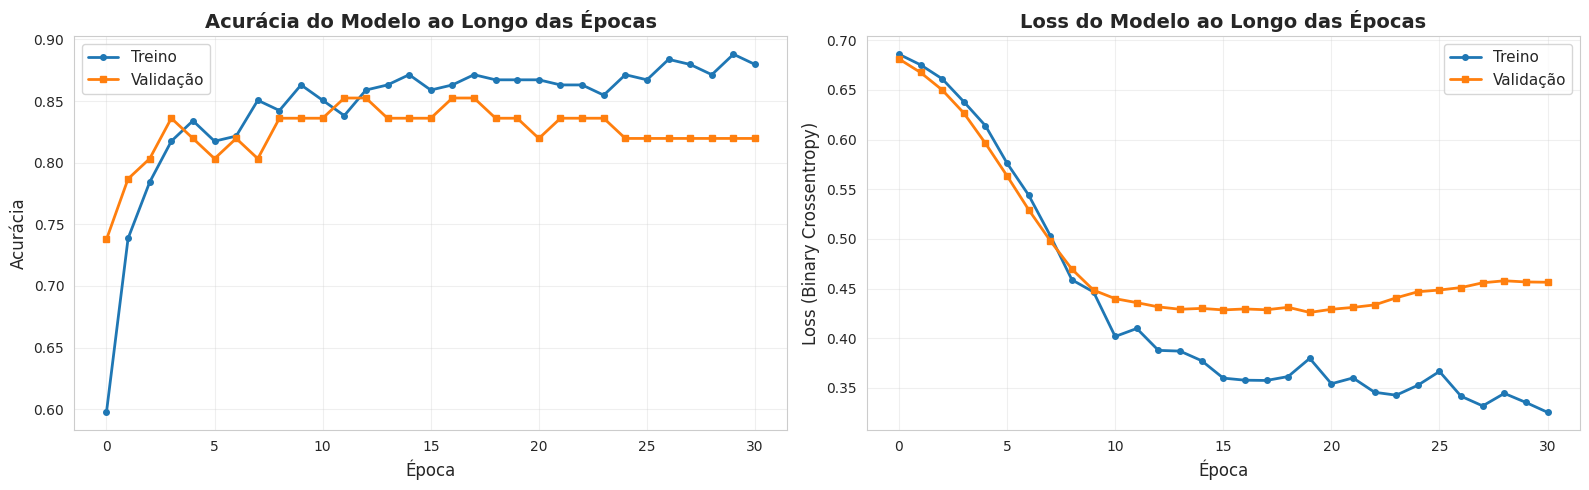


--- Análise do Melhor Modelo (Restaurado pelo EarlyStopping) ---
🔎 Melhor época encontrada: 20 (índice 19)
   - Menor 'val_loss' registrada: 0.4260
   - Acurácia de validação nessa época: 0.8361

--- Avaliando o Modelo Final (Restaurado para a Melhor Época) ---
Acurácia final (treino): 0.8672
Acurácia final (validação): 0.8361
Diferença: 0.0312

--- Diagnóstico de Overfitting ---
Acurácia de Treino:    0.8672
Acurácia de Validação: 0.8361
Diferença (Gap):       0.0312
✅ Ótimo: O modelo está bem generalizado! (Diferença <= 5%)


In [334]:
import matplotlib.pyplot as plt

# Criar figura com 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de Acurácia
ax1.plot(history.history['accuracy'], label='Treino', linewidth=2, marker='o', markersize=4)
ax1.plot(history.history['val_accuracy'], label='Validação', linewidth=2, marker='s', markersize=4)
ax1.set_title('Acurácia do Modelo ao Longo das Épocas', fontsize=14, fontweight='bold')
ax1.set_ylabel('Acurácia', fontsize=12)
ax1.set_xlabel('Época', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Gráfico de Loss
ax2.plot(history.history['loss'], label='Treino', linewidth=2, marker='o', markersize=4)
ax2.plot(history.history['val_loss'], label='Validação', linewidth=2, marker='s', markersize=4)
ax2.set_title('Loss do Modelo ao Longo das Épocas', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss (Binary Crossentropy)', fontsize=12)
ax2.set_xlabel('Época', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise dos gráficos
import numpy as np

# ... seu código do .fit() terminou aqui

print("\n--- Análise do Melhor Modelo (Restaurado pelo EarlyStopping) ---")

# 1. Encontrar a melhor época (com base na menor 'val_loss')
best_epoch_index = np.argmin(history.history['val_loss'])
best_epoch_num = best_epoch_index + 1  # +1 pois os índices são base 0

print(f"🔎 Melhor época encontrada: {best_epoch_num} (índice {best_epoch_index})")
print(f"   - Menor 'val_loss' registrada: {history.history['val_loss'][best_epoch_index]:.4f}")
print(f"   - Acurácia de validação nessa época: {history.history['val_accuracy'][best_epoch_index]:.4f}")


print("\n--- Avaliando o Modelo Final (Restaurado para a Melhor Época) ---")

# 2. Avalia o modelo ATUAL (que foi restaurado para os pesos da melhor época)
# Estes scores devem bater com os valores da 'history' acima.
score_train = binary_model.evaluate(X_train, y_train, verbose=0)
score_test = binary_model.evaluate(X_test, y_test, verbose=0)

# O índice [1] é a acurácia (pois [0] é a loss)
print(f"Acurácia final (treino): {score_train[1]:.4f}")
print(f"Acurácia final (validação): {score_test[1]:.4f}") # <--- ESTE É O NÚMERO CERTO
print(f"Diferença: {score_train[1] - score_test[1]:.4f}")


# 1. Extrai as acurácias (índice [1])
train_acc = score_train[1]
val_acc = score_test[1]

# 2. Calcula a diferença
overfitting_diff = train_acc - val_acc

print("\n--- Diagnóstico de Overfitting ---")
print(f"Acurácia de Treino:    {train_acc:.4f}")
print(f"Acurácia de Validação: {val_acc:.4f}")
print(f"Diferença (Gap):       {overfitting_diff:.4f}")

# 3. Faz a verificação com base nos seus limites
if overfitting_diff > 0.1:
    print("🚨 Alerta: Overfitting significativo! (Diferença > 10%)")
elif overfitting_diff > 0.05:
    print("⚠️ Atenção: Overfitting leve a moderado. (Diferença entre 5% e 10%)")
else:
    print("✅ Ótimo: O modelo está bem generalizado! (Diferença <= 5%)")

## 20. Métricas de Avaliação Final (Acurácia, Precisão, Recall)

Após o treino, usamos o modelo final (restaurado para a melhor época pelo *Early Stopping*) para fazer previsões no conjunto de teste (`X_test`), que ele nunca viu.

As métricas de avaliação são calculadas comparando as previsões (`binary_pred`) com os rótulos reais (`y_test_binary`).

* **Acurácia (83.61%):** O modelo acertou 83.61% de todas as previsões. Como o dataset é balanceado, esta é uma métrica válida.
* **Precisão (Classe 1 "Com Doença") (84.85%):** Das vezes que o modelo previu "Com Doença" (TP + FP), ele estava correto em 84.85% dos casos.
* **Recall (Classe 1 "Com Doença") (84.85%):** Esta é a métrica mais crítica para este problema. Ela indica que o modelo foi capaz de identificar corretamente **84.85%** de todos os pacientes que *realmente* tinham a doença (TP + FN). Um Recall alto é o objetivo em diagnósticos médicos, pois prioriza a minimização de **Falsos Negativos** (casos de doença não detectados).

In [335]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

# Fazer predições no conjunto de teste
y_pred_proba = binary_model.predict(X_test)
binary_pred = np.round(y_pred_proba).astype(int)

# Calcular métricas individuais
accuracy = accuracy_score(y_test_binary, binary_pred)
precision = precision_score(y_test_binary, binary_pred)
recall = recall_score(y_test_binary, binary_pred)

# Apresentação profissional das métricas
print("=" * 70)
print(" " * 20 + "AVALIAÇÃO FINAL DO MODELO")
print("=" * 70)
print(f"\n Métricas de Performance no Conjunto de Teste:")
print(f"\n   • Acurácia:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Precisão:  {precision:.4f} ({precision*100:.2f}%)")
print(f"   • Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"\n" + "=" * 70)
print(" " * 25 + "RELATÓRIO DETALHADO")
print("=" * 70 + "\n")
print(classification_report(y_test_binary, binary_pred,
                          target_names=['Sem Doença (0)', 'Com Doença (1)']))
print("=" * 70)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
                    AVALIAÇÃO FINAL DO MODELO

 Métricas de Performance no Conjunto de Teste:

   • Acurácia:  0.8361 (83.61%)
   • Precisão:  0.8485 (84.85%)
   • Recall:    0.8485 (84.85%)

                         RELATÓRIO DETALHADO

                precision    recall  f1-score   support

Sem Doença (0)       0.82      0.82      0.82        28
Com Doença (1)       0.85      0.85      0.85        33

      accuracy                           0.84        61
     macro avg       0.83      0.83      0.83        61
  weighted avg       0.84      0.84      0.84        61



## 18. Matriz de Confusão

A Matriz de Confusão oferece uma visualização detalhada do desempenho do classificador, mostrando exatamente onde o modelo acertou e onde errou.

* **Verdadeiros Negativos (TN) - 23:** O modelo previu corretamente 23 pacientes como "Sem Doença".
* **Falsos Positivos (FP) - 5:** O modelo previu incorretamente 5 pacientes saudáveis como "Com Doença". (Erro Tipo I - Custo: exames desnecessários).
* **Falsos Negativos (FN) - 5:** O modelo previu incorretamente 5 pacientes doentes como "Sem Doença". (Erro Tipo II - Custo: risco de vida, é o erro mais grave).
* **Verdadeiros Positivos (TP) - 28:** O modelo previu corretamente 28 pacientes como "Com Doença".

**Análise da Matriz:**
A matriz confirma o **bom Recall** (Sensibilidade) do modelo:
$Recall = TP / (TP + FN) = 28 / (28 + 5) = 0.848$ (84.8%).
O modelo foi muito eficaz em encontrar os casos positivos reais, errando 5 dos 33 pacientes doentes.

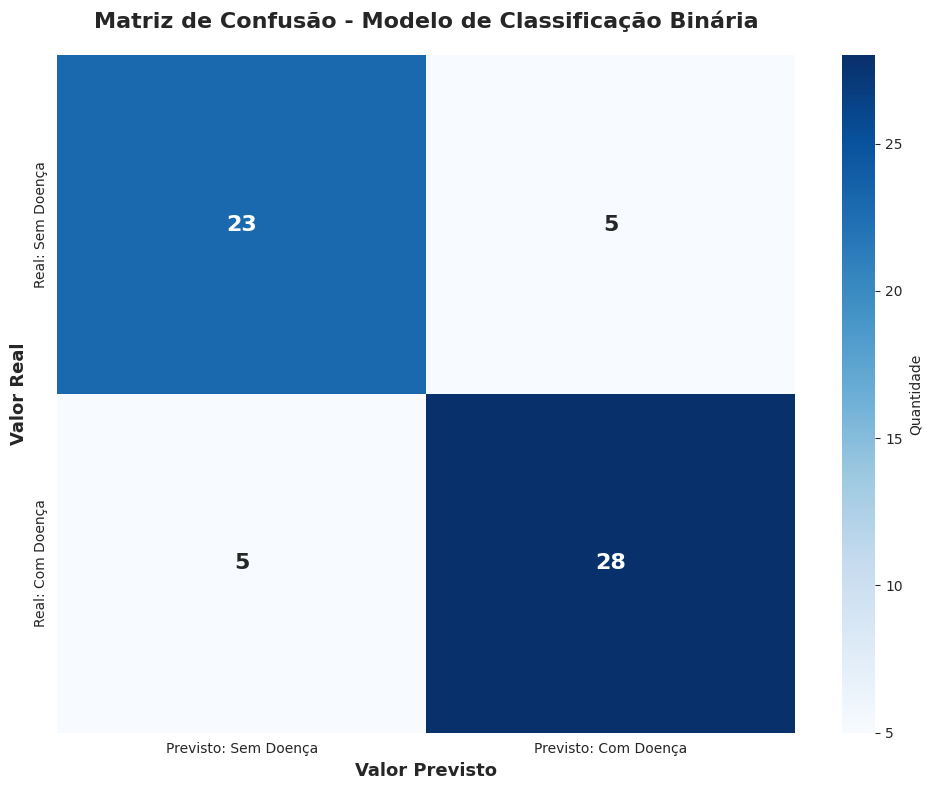


                    INTERPRETAÇÃO DA MATRIZ DE CONFUSÃO

 Análise dos Resultados:

    Verdadeiros Negativos (TN): 23
      → Pacientes SEM doença corretamente identificados como saudáveis

    Falsos Positivos (FP): 5
      → Pacientes SEM doença incorretamente identificados como doentes
      → (Erro Tipo I - causaria exames desnecessários)

    Falsos Negativos (FN): 5
      → Pacientes COM doença incorretamente identificados como saudáveis
      → (Erro Tipo II - mais grave em diagnósticos médicos!)

    Verdadeiros Positivos (TP): 28
      → Pacientes COM doença corretamente identificados como doentes


 Resumo:
   • Total de predições: 61
   • Predições corretas: 51 (83.61%)
   • Predições incorretas: 10 (16.39%)


In [336]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular a Matriz de Confusão
cm_binary = confusion_matrix(y_test_binary, binary_pred)

# Plotar a Matriz de Confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm_binary,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Previsto: Sem Doença', 'Previsto: Com Doença'],
            yticklabels=['Real: Sem Doença', 'Real: Com Doença'],
            cbar_kws={'label': 'Quantidade'},
            annot_kws={'size': 16, 'weight': 'bold'})

plt.title('Matriz de Confusão - Modelo de Classificação Binária',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=13, fontweight='bold')
plt.xlabel('Valor Previsto', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretação detalhada da matriz
print("\n" + "=" * 70)
print(" " * 20 + "INTERPRETAÇÃO DA MATRIZ DE CONFUSÃO")
print("=" * 70)
print(f"\n Análise dos Resultados:\n")
print(f"    Verdadeiros Negativos (TN): {cm_binary[0,0]}")
print(f"      → Pacientes SEM doença corretamente identificados como saudáveis")
print(f"\n    Falsos Positivos (FP): {cm_binary[0,1]}")
print(f"      → Pacientes SEM doença incorretamente identificados como doentes")
print(f"      → (Erro Tipo I - causaria exames desnecessários)")
print(f"\n    Falsos Negativos (FN): {cm_binary[1,0]}")
print(f"      → Pacientes COM doença incorretamente identificados como saudáveis")
print(f"      → (Erro Tipo II - mais grave em diagnósticos médicos!)")
print(f"\n    Verdadeiros Positivos (TP): {cm_binary[1,1]}")
print(f"      → Pacientes COM doença corretamente identificados como doentes")
print("\n" + "=" * 70)

# Cálculos adicionais
total_predictions = cm_binary.sum()
correct_predictions = cm_binary[0,0] + cm_binary[1,1]
incorrect_predictions = cm_binary[0,1] + cm_binary[1,0]

print(f"\n Resumo:")
print(f"   • Total de predições: {total_predictions}")
print(f"   • Predições corretas: {correct_predictions} ({(correct_predictions/total_predictions)*100:.2f}%)")
print(f"   • Predições incorretas: {incorrect_predictions} ({(incorrect_predictions/total_predictions)*100:.2f}%)")
print("=" * 70)